# Imports

In [7]:
from datasets import load_dataset
from random import randint
import gzip
import pandas as pd
import requests
import os
from tqdm import tqdm
import csv
import json
from beir import util
from beir.datasets.data_loader import GenericDataLoader
from transformers import AutoConfig, AutoModel, AutoTokenizer, RobertaTokenizer
import pandas as pd
os.environ["JAVA_HOME"] = "/usr/lib64/openjdk-21"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
from pyserini.search.lucene import LuceneSearcher
from random import randint
import csv
from preprocessing.preprocess_utils import get_pairs_dataloader

import dotenv
dotenv.load_dotenv()

True

In [2]:
os.getenv("JAVA_HOME")

'/usr/lib64/openjdk-21'

# Analysis
In the following section I'll try to find long-context tasks to work on. To do so, I'll download them and look at their size. 

## Qasper
Qasper is a QA dataset made from scientific articles. This makes it naturally long-context dataset, with 3 700 word on average. With some effort, I could transform it into a retrieval dataset.

In [2]:
qasper = load_dataset("allenai/qasper", split="train")

Generating test split: 100%|██████████| 416/416 [00:00<00:00, 2385.69 examples/s]


In [39]:
qasper[0]["qas"]

{'question': ['What is the seed lexicon?',
  'What are the results?',
  'How are relations used to propagate polarity?',
  'How big is the Japanese data?',
  'What are labels available in dataset for supervision?',
  'How big are improvements of supervszed learning results trained on smalled labeled data enhanced with proposed approach copared to basic approach?',
  'How does their model learn using mostly raw data?',
  'How big is seed lexicon used for training?',
  'How large is raw corpus used for training?'],
 'question_id': ['753990d0b621d390ed58f20c4d9e4f065f0dc672',
  '9d578ddccc27dd849244d632dd0f6bf27348ad81',
  '02e4bf719b1a504e385c35c6186742e720bcb281',
  '44c4bd6decc86f1091b5fc0728873d9324cdde4e',
  '86abeff85f3db79cf87a8c993e5e5aa61226dc98',
  'c029deb7f99756d2669abad0a349d917428e9c12',
  '39f8db10d949c6b477fa4b51e7c184016505884f',
  'd0bc782961567dc1dd7e074b621a6d6be44bb5b4',
  'a592498ba2fac994cd6fad7372836f0adb37e22a'],
 'nlp_background': ['two',
  'two',
  'two',
  'two

In [101]:
# Randomly sample nb_examples examples
#nb_examples = len(qasper)
avg_text_len = []
for i in range(len(qasper)):
    text_len = 0
    example = qasper[i]["full_text"]["paragraphs"]

    for par in example:
        text_len += sum([text.count(" ") + 1 for text in par])

    avg_text_len.append(text_len)

qasper_lengths = pd.Series(avg_text_len)
qasper_lengths.describe()

count      888.000000
mean      3718.864865
std       2254.151393
min          0.000000
25%       2387.500000
50%       3527.000000
75%       4353.000000
max      25910.000000
dtype: float64

## NQ

### HuggingFace
In this one I'll first check out Google Research's original Natual Question, instead of BEIR. Ok so Google Research's version is completely uncleaned, making it difficult to deal with. BEIR's version is split into passages. However, if you reconstruct the original article using the titles, you end up with a decently long corpus, roughly 1800 words long on average. 

In this section I'll check out the data format available on huggingface directly. 


In [52]:
nq = load_dataset("BeIR/nq", "corpus", token=os.getenv("HF_TOKEN"), trust_remote_code=True)

Generating corpus split: 100%|██████████| 2681468/2681468 [00:17<00:00, 150277.50 examples/s]


In [ ]:
nq["corpus"]

{'_id': 'doc0',
 'title': 'Minority interest',
 'text': "In accounting, minority interest (or non-controlling interest) is the portion of a subsidiary corporation's stock that is not owned by the parent corporation. The magnitude of the minority interest in the subsidiary company is generally less than 50% of outstanding shares, or the corporation would generally cease to be a subsidiary of the parent.[1]"}

In [ ]:
def grouping_func(input):
    _id = input["_id"].iloc[0]
    text = " ".join(input["text"])

    return pd.Series([_id, text], index=["_id", "text"])

nq_df = pd.DataFrame.from_dict(nq["corpus"])
grouped_nq_df = nq_df.groupby("title").apply(grouping_func)

In [103]:
(grouped_nq_df["text"].str.count(" ") + 1).describe()

count    108593.000000
mean       1872.470380
std        2435.234843
min           1.000000
25%         390.000000
50%        1007.000000
75%        2358.000000
max       68964.000000
Name: text, dtype: float64

### BEIR
Here I'll check out the data available on BEIR's repo. There are two downloadable NQ datasets: nq.zip and nq-train.zip. The train file is larger, somehow. 

In [2]:
out_dir = "/Tmp/lvpoellhuber/datasets/nq"

In [3]:
url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/nq.zip"
data_path = util.download_and_unzip(url, out_dir)

In [4]:
data_path

'/Tmp/lvpoellhuber/datasets/nq/nq'

In [5]:
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

100%|██████████| 2681468/2681468 [00:08<00:00, 327178.62it/s]


In [30]:
corpus_lengths = []

for docid, item in tqdm(corpus.items()):
    text = item["text"]+" "+item["title"]
    if text.count(" ")>=512:
        corpus_lengths.append(512)
    else:
        corpus_lengths.append(text.count(" "))

100%|██████████| 2681468/2681468 [00:04<00:00, 607620.10it/s]


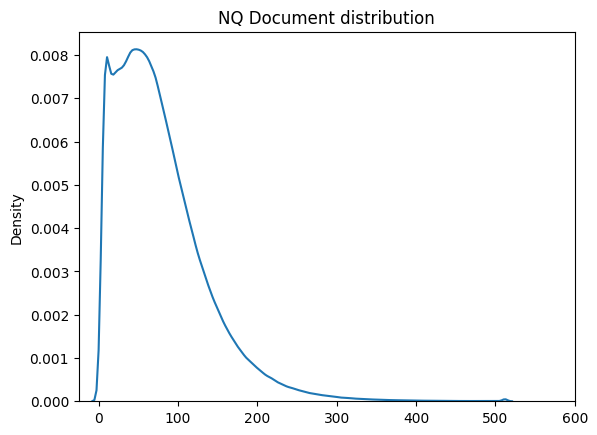

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(corpus_lengths)
plt.xlim([-25, 600])
plt.title("NQ Document distribution")
plt.show()

In [15]:
pd.Series(corpus_lengths).describe().round()

count    2681468.0
mean          78.0
std           59.0
min            1.0
25%           36.0
50%           67.0
75%          106.0
max         5420.0
dtype: float64

In [17]:
ms_corpus, ms_queries, ms_qrels = GenericDataLoader(data_folder="/Tmp/lvpoellhuber/datasets/msmarco-doc").load(split="test")

100%|██████████| 3201821/3201821 [00:54<00:00, 58518.42it/s]


In [28]:
ms_corpus_lengths = []

for docid, item in tqdm(ms_corpus.items()):
    text = item["text"]+" "+item["title"]
    if text.count(" ")>=4096:
        ms_corpus_lengths.append(4096)
    else:
        ms_corpus_lengths.append(text.count(" "))

  0%|          | 0/3201821 [00:00<?, ?it/s]

100%|██████████| 3201821/3201821 [00:50<00:00, 63974.11it/s]


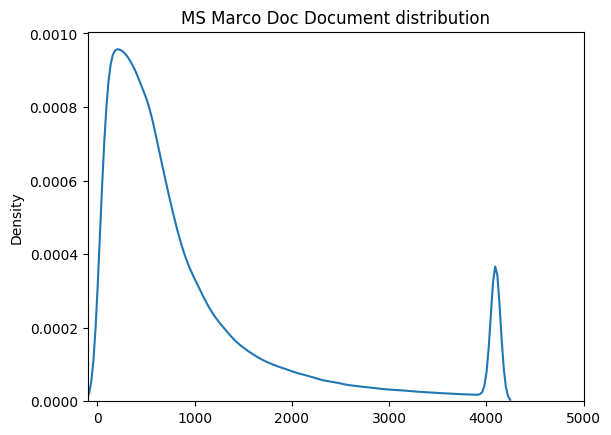

In [29]:
sns.kdeplot(ms_corpus_lengths)
plt.xlim([-100, 5000])
plt.title("MS Marco Doc Document distribution")
plt.show()

In [ ]:
qs = []

for query in queries:
    qs.append(len(queries[query]))

max(qs)

100

In [17]:
queries

{'test0': 'what is non controlling interest on balance sheet',
 'test1': 'how many episodes are in chicago fire season 4',
 'test2': 'who sings love will keep us alive by the eagles',
 'test3': 'who is the leader of the ontario pc party',
 'test4': 'nitty gritty dirt band fishin in the dark album',
 'test5': 'who were the three elves who got rings',
 'test6': 'converting stereo signal to mono signal is called',
 'test7': 'in order to prove disparate impact you first must establish',
 'test8': 'where do characters live in this is us',
 'test9': 'who makes the decisions about what to produce in a market economy',
 'test10': 'when is the new tappan zee bridge going to be finished',
 'test11': "who recorded i can't help falling in love with you",
 'test12': 'who plays the doc in back to the future',
 'test13': 'when did they stop cigarette advertising on television',
 'test14': "who has been chosen as the brand ambassador of the campaign 'beti bachao-beti padhao",
 'test15': 'how many seas

### Create a short dataset
I'm creating a short version of the test dataset, made up of 500 queries. To maintain the same balance as the regular corpus, I need to have a total 319146 documents in my corpus, containing the 500 queries' positive documents.

Calculate the number of positive documents.

In [7]:
qrel_len = 0
for qid in qrels:
    qrel_len += len(qrels[qid])
qrel_len

4201

Grab all the qrels, queries and the positive documents. 

In [ ]:
short_corpus = {}
short_queries = {}
short_qrels = {}
i = 0
for qid in qrels:
    if i == 500: break
    query = queries[qid]
    docids = qrels[qid]

    documents = []
    for docid in docids:
        short_corpus[docid] = corpus[docid]
    
    short_qrels[qid] = docids
    short_queries[qid] = query

    i+=1

Compute the short corpus' sized, balanced like the original corpus. 

In [9]:
short_corpus_size = round(500*len(corpus)/qrel_len)
leftover_corpus_size = short_corpus_size - len(short_corpus)
leftover_corpus_size

318523

Grab a list of all the positive docids. 

In [10]:
positive_docids = short_corpus.keys()
positive_docids

dict_keys(['doc0', 'doc1', 'doc6', 'doc10', 'doc17', 'doc18', 'doc42', 'doc50', 'doc59', 'doc63', 'doc67', 'doc86', 'doc91', 'doc118', 'doc136', 'doc153', 'doc172', 'doc293', 'doc302', 'doc305', 'doc449', 'doc450', 'doc514', 'doc565', 'doc579', 'doc618', 'doc635', 'doc649', 'doc653', 'doc658', 'doc698', 'doc703', 'doc724', 'doc763', 'doc787', 'doc789', 'doc807', 'doc820', 'doc824', 'doc897', 'doc908', 'doc916', 'doc921', 'doc967', 'doc972', 'doc1010', 'doc1016', 'doc1026', 'doc1042', 'doc1070', 'doc1071', 'doc1100', 'doc1118', 'doc1154', 'doc1164', 'doc1187', 'doc1193', 'doc1215', 'doc1229', 'doc1239', 'doc1260', 'doc1404', 'doc1405', 'doc1407', 'doc1420', 'doc1432', 'doc1448', 'doc1468', 'doc1474', 'doc1486', 'doc1490', 'doc1541', 'doc1580', 'doc1599', 'doc1617', 'doc1631', 'doc1679', 'doc1684', 'doc1729', 'doc1744', 'doc1754', 'doc1771', 'doc1774', 'doc1782', 'doc1824', 'doc1927', 'doc2000', 'doc2030', 'doc2107', 'doc2127', 'doc2134', 'doc2151', 'doc2254', 'doc2262', 'doc2274', 'doc2

Randomly sample the corpus until we reach the desired size, ignoring positive docids. 

In [11]:
while (len(short_corpus) < short_corpus_size):
    random_int = randint(0, len(corpus))
    random_docid = f"doc{random_int}"

    if random_docid not in positive_docids:
        short_corpus[random_docid] = corpus[random_docid]


Save locally, to nq/nq-short. 

In [29]:
with open("/Tmp/lvpoellhuber/datasets/nq/nq-short/corpus.jsonl", "w", encoding="utf-8") as f:
    for doc_id, doc_content in short_corpus.items():
        json.dump({"_id": doc_id, **doc_content}, f)
        f.write("\n") 

In [30]:
with open("/Tmp/lvpoellhuber/datasets/nq/nq-short/queries.jsonl", "w", encoding="utf-8") as f:
    for qid, query in short_queries.items():
        json.dump({"_id": qid, "text": query, "metadata": {}}, f)
        f.write("\n") 

In [24]:

# Save as TSV file
with open("/Tmp/lvpoellhuber/datasets/nq/nq-short/qrels/test.tsv", "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f, delimiter="\t")  # Use tab as delimiter
    
    # Write header
    writer.writerow(["query-id", "corpus-id", "score"])
    
    # Write rows
    for qid, docids in short_qrels.items():
        for docid in docids:
            writer.writerow([qid, docid, 1])

Test it!

In [31]:
short_datapath = "/Tmp/lvpoellhuber/datasets/nq/nq-short"
corpus, queries, qrels = GenericDataLoader(data_folder=short_datapath).load(split="test")

100%|██████████| 319146/319146 [00:00<00:00, 358186.33it/s]


In [32]:
len(corpus)

319146

### Create a pre-tokenized dataset

In [ ]:
from preprocessing.preprocess_utils import get_pairs_dataloader
from beir.retrieval.models.util import extract_corpus_sentences
import torch

In [4]:
pairs_path = "/Tmp/lvpoellhuber/datasets/nq/train_pairs.pt"

dataloader = get_pairs_dataloader(32, pairs_path)

In [5]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased", use_fast=True)

In [6]:

class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, encodings):
        self.encodings = encodings
        
    def __len__(self):
        return self.encodings["input_ids"].shape[0]
    
    def __getitem__(self, i):
        return  {key: tensor[i] for key, tensor in self.encodings.items()}
    
    def save(self, save_path):
        torch.save(self.encodings, save_path)

In [12]:
q_input_ids = []
q_ttids = []
q_attn_mask = []
doc_input_ids = []
doc_ttids = []
doc_attn_mask = []
for batch in tqdm(dataloader):
    queries = batch["queries"]
    documents = batch["documents"]
    sentences = [(doc["title"] + " [SEP] " + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in documents]
    
    tokenized_queries = tokenizer(queries, truncation=True, padding=True, return_tensors="pt")
    tokenized_documents = tokenizer(sentences, truncation=True, padding=True, return_tensors="pt")

    q_input_ids.append(tokenized_queries["input_ids"])
    q_ttids.append(tokenized_queries["token_type_ids"])
    q_attn_mask.append(tokenized_queries["attention_mask"])
    doc_input_ids.append(tokenized_documents["input_ids"])
    doc_ttids.append(tokenized_documents["token_type_ids"])
    doc_attn_mask.append(tokenized_documents["attention_mask"])

# q_input_ids = torch.cat(q_input_ids)
# q_ttids = torch.cat(q_ttids)
# q_attn_mask = torch.cat(q_attn_mask)
# doc_input_ids = torch.cat(doc_input_ids)
# doc_ttids = torch.cat(doc_ttids)
# doc_attn_mask = torch.cat(doc_attn_mask)

encodings = {
    "queries": {
        "input_ids": q_input_ids, 
        "ttids": q_ttids, 
        "attention_mask": q_attn_mask,
        },
    "documents": {
        "input_ids": doc_input_ids, 
        "ttids": doc_ttids, 
        "attention_mask": doc_attn_mask,
    }
}


  0%|          | 0/4151 [00:00<?, ?it/s]

100%|██████████| 4151/4151 [01:09<00:00, 59.51it/s]


In [9]:
q_input_ids[0].shape

torch.Size([32, 19])

In [10]:
q_input_ids[1].shape

torch.Size([32, 20])

In [11]:
q_input_ids[2].shape

torch.Size([32, 17])

In [13]:
dataset = Dataset(encodings)
dataset.save("/Tmp/lvpoellhuber/datasets/nq/train_pairs_tokenized.pt")

## Arguana
I'm not too sure what kind of dataset Arguana is, but it is damn long,with 7800 word on average!

In [104]:
arguana = load_dataset("BeIR/arguana", "corpus", token=os.getenv("HF_TOKEN"), trust_remote_code=True)

Generating corpus split: 100%|██████████| 8674/8674 [00:00<00:00, 75092.92 examples/s]


In [105]:
arguana["corpus"]

Dataset({
    features: ['_id', 'title', 'text'],
    num_rows: 8674
})

In [106]:
def grouping_func(input):
    _id = input["_id"].iloc[0]
    text = " ".join(input["text"])

    return pd.Series([_id, text], index=["_id", "text"])

arguana_df = pd.DataFrame.from_dict(arguana["corpus"])
grouped_arguana_df = arguana_df.groupby("title").apply(grouping_func)

/tmp/ipykernel_2134186/3181241254.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_arguana_df = arguana_df.groupby("title").apply(grouping_func)


In [109]:
(grouped_arguana_df["text"].str.count(" ") + 1).describe()

count    1.840000e+02
mean     7.854114e+03
std      7.444053e+04
min      4.480000e+02
25%      1.859250e+03
50%      2.268000e+03
75%      2.694000e+03
max      1.012057e+06
Name: text, dtype: float64

## Touche 2020

In [110]:
web = load_dataset("BeIR/webis-touche2020", "corpus", token=os.getenv("HF_TOKEN"), trust_remote_code=True)

Generating corpus split: 100%|██████████| 382545/382545 [00:07<00:00, 49889.55 examples/s] 


In [111]:
web["corpus"]

Dataset({
    features: ['_id', 'title', 'text'],
    num_rows: 382545
})

In [112]:
def grouping_func(input):
    _id = input["_id"].iloc[0]
    text = " ".join(input["text"])

    return pd.Series([_id, text], index=["_id", "text"])

web_df = pd.DataFrame.from_dict(web["corpus"])
grouped_web_df = web_df.groupby("title").apply(grouping_func)

/tmp/ipykernel_2134186/1650408127.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_web_df = web_df.groupby("title").apply(grouping_func)


In [113]:
(grouped_web_df["text"].str.count(" ") + 1).describe()

count     72121.000000
mean       1519.150095
std        4258.727238
min           1.000000
25%         159.000000
50%         533.000000
75%        1774.000000
max      729511.000000
Name: text, dtype: float64

## HotpotQA

While it's a very common QA dataset, it's not a very long one. 

In [115]:
hpqa = load_dataset("hotpotqa/hotpot_qa", "fullwiki", token=os.getenv("HF_TOKEN"), trust_remote_code=True)

Generating test split: 100%|██████████| 7405/7405 [00:05<00:00, 1441.31 examples/s]


In [117]:
hpqa["train"]

Dataset({
    features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
    num_rows: 90447
})

In [136]:
len(hpqa["train"][0]["context"]["sentences"])
hpqa["train"][0]["context"]

{'title': ['Radio City (Indian radio station)',
  'History of Albanian football',
  'Echosmith',
  "Women's colleges in the Southern United States",
  'First Arthur County Courthouse and Jail',
  "Arthur's Magazine",
  '2014–15 Ukrainian Hockey Championship',
  'First for Women',
  'Freeway Complex Fire',
  'William Rast'],
 'sentences': [["Radio City is India's first private FM radio station and was started on 3 July 2001.",
   ' It broadcasts on 91.1 (earlier 91.0 in most cities) megahertz from Mumbai (where it was started in 2004), Bengaluru (started first in 2001), Lucknow and New Delhi (since 2003).',
   ' It plays Hindi, English and regional songs.',
   ' It was launched in Hyderabad in March 2006, in Chennai on 7 July 2006 and in Visakhapatnam October 2007.',
   ' Radio City recently forayed into New Media in May 2008 with the launch of a music portal - PlanetRadiocity.com that offers music related news, videos, songs, and other music-related features.',
   ' The Radio station c

## MS Marco Document Retrieval Track

With some effort, I can download and convert this to a document retrieval task. 

## Conclusion
In conclusion, many of the long-context tasks I found come from a modification of BEIR. These include NQ, Arguana and Touche 2020. Qasper is another great choice, the best being MS Marco. 


# Pre Processing
Most datasets will need some degree of preprocessing: whether they are QA or reranking, I'll need to reformulate the problem as a document ranking task. 

## MS Marco
This task will probably be the most demanding in terms of preprocessing: it's not even available on Datasets.

In [6]:
def download_url(url: str, save_path: str, chunk_size: int = 1024):
    """Download url with progress bar using tqdm
    https://stackoverflow.com/questions/15644964/python-progress-bar-and-downloads

    Args:
        url (str): downloadable url
        save_path (str): local path to save the downloaded file
        chunk_size (int, optional): chunking of files. Defaults to 1024.
    """
    r = requests.get(url, stream=True)
    total = int(r.headers.get("Content-Length", 0))
    with (
        open(save_path, "wb") as fd,
        tqdm(
            desc=save_path,
            total=total,
            unit="iB",
            unit_scale=True,
            unit_divisor=chunk_size,
        ) as bar,
    ):
        for data in r.iter_content(chunk_size=chunk_size):
            size = fd.write(data)
            bar.update(size)


In [7]:
files = ["msmarco-docs.trec.gz", "msmarco-docs-lookup.tsv.gz", "msmarco-doctrain-queries.tsv.gz", "msmarco-doctrain-top100.gz", "msmarco-doctrain-qrels.tsv.gz", "msmarco-docdev-queries.tsv.gz", "msmarco-docdev-top100.gz", "msmarco-docdev-qrels.tsv.gz", "docleaderboard-queries.tsv.gz", "docleaderboard-top100.gz"]
url = " /"
save_dir = "/Tmp/lvpoellhuber/datasets/msmarco-doc"

for download_file in files:
    file_url = url + download_file
    save_path = os.path.join(save_dir, download_file)
    
    if os.path.exists(save_path):
        print("Download already exists. ")
    else:
        download_url(url = file_url, save_path = save_path)

Download already exists. 
Download already exists. 
Download already exists. 
Download already exists. 
Download already exists. 
Download already exists. 
Download already exists. 
Download already exists. 
Download already exists. 
Download already exists. 


In [8]:
storage_dir = "/Tmp/lvpoellhuber/datasets/msmarco-doc/"

In [6]:
# The query string for each topicid is querystring[topicid]
querystring = {}
with gzip.open(storage_dir + "msmarco-docdev-queries.tsv.gz", 'rt', encoding='utf8') as f:
    tsvreader = csv.reader(f, delimiter="\t")
    for [topicid, querystring_of_topicid] in tsvreader:
        querystring[topicid] = querystring_of_topicid

In [7]:
querystring

{'174249': 'does xpress bet charge to deposit money in your account',
 '320792': 'how much is a cost to run disneyland',
 '1090270': 'botulinum definition',
 '1101279': 'do physicians pay for insurance from their salaries?',
 '201376': 'here there be dragons comic',
 '54544': 'blood diseases that are sexually transmitted',
 '118457': 'define bona fides',
 '178627': 'effects of detox juice cleanse',
 '1101278': 'do prince harry and william have last names',
 '68095': 'can hives be a sign of pregnancy',
 '87892': 'causes of petechial hemorrhage',
 '257309': 'how long does it take to get your bsrn if you already have a bachelors degree',
 '1090242': 'symptoms of ptsd in vietnam veterans',
 '211691': 'how coffee works quote',
 '165002': 'does contraction of the ciliary muscles shorten the lens',
 '1101276': 'do spiders eat other animals',
 '264827': 'how long is the flight from chicago to cairo',
 '342285': 'how titanic facts',
 '372586': 'how to play blu ray discs',
 '89786': 'central cit

In [11]:
# In the corpus tsv, each docid occurs at offset docoffset[docid]
docoffset = {}
with gzip.open(storage_dir + "msmarco-docs-lookup.tsv.gz", 'rt', encoding='utf8') as f:
    tsvreader = csv.reader(f, delimiter="\t")
    for [docid, _, offset] in tsvreader:
        docoffset[docid] = int(offset)

In [12]:
docoffset

{'D1555982': 0,
 'D301595': 1852,
 'D1359209': 7973,
 'D2147834': 23656,
 'D1568809': 31104,
 'D3233725': 32233,
 'D1150618': 35109,
 'D1885729': 37298,
 'D1311240': 38964,
 'D3048094': 57457,
 'D2342771': 59170,
 'D1840066': 65036,
 'D3085586': 68974,
 'D62203': 71304,
 'D2883971': 73803,
 'D1911483': 79057,
 'D1281784': 87676,
 'D2347744': 90681,
 'D560769': 92990,
 'D1050302': 97356,
 'D207561': 98507,
 'D15500': 103732,
 'D488904': 105214,
 'D330566': 111733,
 'D1270076': 117733,
 'D205553': 119686,
 'D2976645': 125084,
 'D2520478': 127718,
 'D2641659': 129109,
 'D3058536': 129523,
 'D2175291': 130327,
 'D2702544': 132001,
 'D3257085': 135273,
 'D495191': 137242,
 'D2380450': 139142,
 'D2435215': 141278,
 'D1247413': 145672,
 'D2442854': 149244,
 'D2173367': 160104,
 'D2111530': 168026,
 'D2378859': 172668,
 'D2435425': 176248,
 'D885257': 180175,
 'D2900586': 181779,
 'D2981241': 184778,
 'D7792': 193188,
 'D3261752': 204070,
 'D1163231': 210534,
 'D1683937': 213235,
 'D1256481': 

In [13]:
# For each topicid, the list of positive docids is qrel[topicid]
qrel = {}
with gzip.open(storage_dir + "msmarco-docdev-qrels.tsv.gz", 'rt', encoding='utf8') as f:
    tsvreader = csv.reader(f, delimiter="\t")
    for item in tsvreader:
        topicid, _, docid, rel = item[0].split(" ")
        assert rel == "1"
        
        qrel[topicid] = docid


In [14]:
qrel

{'2': 'D1650436',
 '1215': 'D1202771',
 '1288': 'D1547717',
 '1576': 'D1313702',
 '2235': 'D2113408',
 '2798': 'D2830290',
 '2962': 'D125453',
 '4696': 'D2523421',
 '4947': 'D2001134',
 '6217': 'D1361055',
 '6791': 'D2312537',
 '7968': 'D3201313',
 '8714': 'D1460407',
 '8854': 'D763169',
 '9454': 'D92891',
 '9926': 'D862190',
 '10157': 'D119620',
 '10205': 'D419097',
 '10264': 'D2798507',
 '10276': 'D1000561',
 '10312': 'D782169',
 '11006': 'D728941',
 '11133': 'D815091',
 '12741': 'D660088',
 '12903': 'D855092',
 '13397': 'D1162930',
 '14151': 'D2737200',
 '14963': 'D2070532',
 '15039': 'D1062478',
 '15063': 'D1384820',
 '15382': 'D787707',
 '15607': 'D1157519',
 '16860': 'D3334252',
 '17586': 'D22461',
 '17635': 'D344906',
 '17848': 'D1036473',
 '18101': 'D1059660',
 '18840': 'D1651387',
 '19457': 'D429050',
 '19552': 'D1751087',
 '19940': 'D1441295',
 '20356': 'D1091563',
 '20597': 'D851017',
 '20671': 'D300352',
 '21741': 'D306639',
 '21765': 'D1001231',
 '21861': 'D1205368',
 '219

In [16]:
# This function seeks the docid in the TSV file. It's to make it easier to access since it's so huge. 
def getcontent(docid, f):
    """getcontent(docid, f) will get content for a given docid (a string) from filehandle f.
    The content has four tab-separated strings: docid, url, title, body.
    """

    f.seek(docoffset[docid])
    line = f.readline()
    assert line.startswith(docid + "\t"), \
        f"Looking for {docid}, found {line}"
    return line.rstrip().split("\t")

with gzip.open(storage_dir + "msmarco-docs.tsv.gz", 'rt', encoding='utf8') as f:
    content = getcontent("D1442741", f)
content

['D1442741',
 'http://www.tarotreadingpsychic.com/love-tarot-three-of-cups/',
 '.',
 'TAROTREADINGPSYCHIC. COMThis page is provided courtesy of Go Daddy.com, LLC. Copyright © 1999-2018 Go Daddy.com, LLC. All rights reserved. Privacy Policy']

### Transforming it into corpus format

In [23]:
out_dir = "/Tmp/lvpoellhuber/datasets/msmarco-doc"

#### qrels

In [53]:
qrel_dir = os.path.join(out_dir, "qrels")
if not os.path.exists(qrel_dir):
    os.makedirs(qrel_dir)
qrel_filepath = os.path.join(qrel_dir, "train.tsv")

with open(qrel_filepath, "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f, delimiter="\t", lineterminator='\n')
    
    writer.writerow(["query-id", "corpus-id", "score"])
    
    for qid, docid in qrel.items():
        writer.writerow([qid, docid, 1])
        

#### queries

In [54]:
queries_filepah = os.path.join(out_dir, "queries.jsonl")

with open(queries_filepah, "w") as f:
    for qid, query in tqdm(querystring.items()):
        json.dump({"_id": qid, "text": query, "metadata": {}}, f)
        f.write("\n")

  0%|          | 0/5193 [00:00<?, ?it/s]

100%|██████████| 5193/5193 [00:00<00:00, 62063.92it/s]


#### corpus

In [60]:
corpus_filepah = os.path.join(out_dir, "corpus.jsonl")
corpus_docids = list(docoffset.keys())

skipped_docids = []
with open(corpus_filepah, "w") as corpus_out, \
    gzip.open(storage_dir + "msmarco-docs.tsv.gz", 'rt', encoding='utf8') as corpus_in:
    for doc_id in tqdm(corpus_docids):
        doc = getcontent(doc_id, corpus_in)
        if len(doc) != 4:
            skipped_docids.append(doc_id)
            continue
        json.dump({"id": doc_id, "title": doc[2], "contents": doc[3]}, corpus_out)
        corpus_out.write("\n")

  0%|          | 0/3213835 [00:00<?, ?it/s]

  0%|          | 520/3213835 [00:03<5:54:12, 151.20it/s]


KeyboardInterrupt: 

In [61]:
skipped_docids

['D1484729', 'D2338213', 'D803785', 'D3360795']

In [81]:
for sid in skipped_docids:
    print(sid in qrel)

False
False
False
False


### Creating a short dataset
I am going to base the length of this dataset on the evaluation time. It took 26h30 to evaluate 5193 test queries, with 3 201 821 documents. With a  simple cross product, to reach an evaluation time of 2h, I need to grab 400 queries, so roughly 8% of the test queries and the corpus. As such, I'll use 8% as the ratio to reduce the dataset with. 

In [2]:
out_dir = "/Tmp/lvpoellhuber/datasets/msmarco-doc-short"
data_path = "/Tmp/lvpoellhuber/datasets/msmarco-doc"
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

100%|██████████| 3201821/3201821 [00:49<00:00, 65109.07it/s]


In [ ]:
reduction_factor = 0.08

nb_queries = round(reduction_factor * len(queries))
nb_documents = round(reduction_factor * len(corpus))

In [ ]:
query_ids = list(queries.keys())

short_corpus = {}
short_queries = {}
short_qrels = {}

randid = randint(0, len(queries))
qid = query_ids[randid]
for i in tqdm(range(nb_queries)):
    while qid in short_queries.keys():
        randid = randint(0, len(queries))
        qid = query_ids[randid]

    query = queries[qid]
    docid = list(qrels[qid].keys())[0]
    short_corpus[docid] = corpus[docid]
    
    short_qrels[qid] = docid
    short_queries[qid] = query

100%|██████████| 415/415 [00:00<00:00, 466408.40it/s]


In [10]:
positive_docids = short_corpus.keys()
all_docids = list(corpus.keys())

In [11]:
while (len(short_corpus) < nb_documents):
    random_int = randint(0, len(corpus))
    random_docid = all_docids[random_int]

    if random_docid not in positive_docids:
        short_corpus[random_docid] = corpus[random_docid]


In [16]:
with open("/Tmp/lvpoellhuber/datasets/msmarco-doc-short/corpus.jsonl", "w", encoding="utf-8") as f:
    for doc_id, doc_content in short_corpus.items():
        json.dump({"_id": doc_id, **doc_content}, f)
        f.write("\n") 

In [17]:
with open("/Tmp/lvpoellhuber/datasets/msmarco-doc-short/queries.jsonl", "w", encoding="utf-8") as f:
    for qid, query in short_queries.items():
        json.dump({"_id": qid, "text": query, "metadata": {}}, f)
        f.write("\n") 

In [ ]:

# Save as TSV file
with open("/Tmp/lvpoellhuber/datasets/msmarco-doc-short/qrels/test.tsv", "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f, delimiter="\t")  # Use tab as delimiter
    
    # Write header
    writer.writerow(["query-id", "corpus-id", "score"])
    
    # Write rows
    for qid, docids in short_qrels.items():
            writer.writerow([qid, docid, 1])

#### Test it!



In [2]:
data_path = "/Tmp/lvpoellhuber/datasets/msmarco-doc-short"
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

100%|██████████| 256146/256146 [00:03<00:00, 76121.77it/s]


In [5]:
qrels

{'1091194': {'D': 1, '3': 1, '2': 1, '4': 1, '5': 1, '9': 1},
 '96310': {'D': 1, '5': 1, '4': 1, '2': 1, '9': 1, '7': 1},
 '1082792': {'D': 1, '1': 1, '2': 1, '8': 1, '7': 1, '0': 1},
 '507221': {'D': 1, '5': 1, '0': 1, '2': 1, '3': 1},
 '1032281': {'D': 1, '3': 1, '1': 1, '6': 1, '0': 1},
 '581521': {'D': 1, '2': 1, '0': 1, '5': 1, '1': 1, '4': 1, '3': 1},
 '188714': {'D': 1, '2': 1, '5': 1, '9': 1},
 '507087': {'D': 1, '1': 1, '9': 1, '3': 1, '8': 1, '6': 1},
 '205741': {'D': 1, '3': 1, '4': 1, '9': 1, '1': 1, '8': 1, '7': 1},
 '1088903': {'D': 1, '7': 1, '6': 1, '9': 1, '4': 1, '8': 1},
 '559709': {'D': 1, '8': 1, '1': 1, '2': 1, '0': 1},
 '905707': {'D': 1, '2': 1, '9': 1, '6': 1, '7': 1, '0': 1, '4': 1},
 '881695': {'D': 1, '2': 1, '6': 1, '9': 1, '4': 1, '5': 1},
 '652912': {'D': 1, '1': 1, '8': 1, '5': 1, '7': 1, '0': 1, '3': 1},
 '1102390': {'D': 1, '1': 1, '0': 1, '7': 1, '3': 1, '2': 1, '4': 1},
 '1071722': {'D': 1, '2': 1, '9': 1, '7': 1, '6': 1, '1': 1, '0': 1},
 '821372': 

In [ ]:
dataloader = get_pairs_dataloader(batch_size = 1, dataset_path="/Tmp/lvpoellhuber/datasets/msmarco-doc/train_pairs.pt")

In [ ]:
short_train_pairs = 
for item in dataloader:

# NQ

In [82]:
out_dir = "/Tmp/lvpoellhuber/datasets/nq"

In [83]:
url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/nq-train.zip"
data_path = util.download_and_unzip(url, out_dir)

In [84]:
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="train")

100%|██████████| 18060996/18060996 [01:21<00:00, 220490.53it/s]


In [15]:
pos_doc_len = {}
for qid in qrels:
    docs = qrels[qid]
    if str(len(docs)) not in pos_doc_len.keys():
        pos_doc_len[str(len(docs))] = 1
    else:
        pos_doc_len[str(len(docs))] += 1
        
pos_doc_len

{'1': 132803}

In [27]:
list(qrels["train0"].keys())[0]

'doc77'

In [9]:
documents = []
for qid, docs in qrels.items():
    for doc in docs:
        documents.append(doc)

unique_docs = pd.Series(documents).unique()
doc_set = set(list(unique_docs))

corpus_set = set(corpus.keys())

overlap = corpus_set.intersection(doc_set)

len(overlap) / len(corpus) * 100

0.7353027485305905

In [11]:
output_file = "/Tmp/lvpoellhuber/datasets/nq/corpus.jsonl"

with open(output_file, "w") as f:
    for doc_id, doc in corpus.items():
        json.dump({"id": doc_id, "title": doc["title"], "contents": doc["text"]}, f)
        f.write("\n")

Then run the following command: 

python -m pyserini.index -collection JsonCollection -input /part/01/Tmp/lvpoellhuber/datasets/nq -index /part/01/Tmp/lvpoellhuber/datasets/nq/bm25index -generator DefaultLuceneDocumentGenerator -threads 4 -storePositions -storeDocvectors -storeRaw


In [5]:
# Load the index
searcher = LuceneSearcher("/Tmp/lvpoellhuber/datasets/nq/bm25index")

# Search with BM25
query = 'when did richmond last play in a preliminary final'
docids = ["doc77"]
hits = searcher.search(query, k=6)  # Get top 6 results. 6 ensures we have at least 5 documents different from the right answer. 

# Print results
for i in range(len(hits)):
    print(f"Rank {i+1}: {hits[i].docid} | Score: {hits[i].score}")


Rank 1: doc553722 | Score: 13.992400169372559
Rank 2: doc10389121 | Score: 13.2746000289917
Rank 3: doc1243114 | Score: 12.989800453186035
Rank 4: doc16370059 | Score: 12.659700393676758
Rank 5: doc8207325 | Score: 12.659699440002441
Rank 6: doc16348311 | Score: 11.469799995422363


In [8]:
neg_docs = []
for i in range(len(hits)):
    if (hits[i].docid not in docids) & (len(neg_docs)<5):
        neg_docs.append(hits[i].docid)
neg_docs

['doc553722', 'doc10389121', 'doc1243114', 'doc16370059', 'doc8207325']